In [6]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [7]:
# Defining Classes
num_range = np.linspace(-1.05,1.05,22)
classes = [[round(num_range[i],3), round(num_range[i+1],3)] for i in range(len(num_range)-1)]

if __name__ == "__main__":
    # classes = [[(i + 5)/10,(i+1)/10] for i in range(-10,10,1)]
    interval = 2/len(classes)
    print(classes)
    print(len(classes))

[[-1.05, -0.95], [-0.95, -0.85], [-0.85, -0.75], [-0.75, -0.65], [-0.65, -0.55], [-0.55, -0.45], [-0.45, -0.35], [-0.35, -0.25], [-0.25, -0.15], [-0.15, -0.05], [-0.05, 0.05], [0.05, 0.15], [0.15, 0.25], [0.25, 0.35], [0.35, 0.45], [0.45, 0.55], [0.55, 0.65], [0.65, 0.75], [0.75, 0.85], [0.85, 0.95], [0.95, 1.05]]
21


In [8]:
def category(angle,minimum,maximum,num_categories):
    if angle == maximum:
        return num_categories-1
    scale = (maximum-minimum)/num_categories
    return math.floor(1/scale*(angle-minimum))

if __name__ == "__main__":
    print(category(-1.05,-1.05,1.05,21))
    print(category(-0.95000000000000001,-1.05,1.05,21))
    print(category(-0.95,-1.05,1.05,21))
    print(category(1.05,-1.05,1.05,21))

0
1
1
20


In [9]:
class ControlsDataset(Dataset):
    """Dataset that maps camera images into steering angle"""
    def __init__(self, stack_size = 1 ,img_folder = 'data/', csv_path='data/data.csv', 
                 classes = classes):
        
        #stack of images through time (ex. last 5 images taken)
        self.stack_size = stack_size
        self.img_folder = img_folder
        # index_col = 0 so panda does not choose its own indexing
        self.classes = classes
        self.data_frame = pd.read_csv(csv_path)
            
    def __len__(self):
        return len(self.data_frame) - self.stack_size
    
    def __getitem__(self, idx):
        img_filenames = ["{0}{1:06d}.jpg".format(self.img_folder, i) 
                            for i in range(idx, idx+self.stack_size)]
        imgs = [io.imread(img_filename).transpose((2,0,1)) for img_filename in img_filenames]
        img_stack = np.concatenate(imgs, axis=0)
        
        # use the latest image as the control
        index = idx+self.stack_size
        num = self.data_frame.iloc[index]["Angle"]
        
        control = num
        control = np.array([control])
        sample = {'image': img_stack, 
                  'control': control}
        
        return sample
    
    def convertTOClass(self):
        def myfunc(angle):
            if angle == 1.05:
                return 20
            return math.floor(10*(angle+1.05))
        
        self.data_frame.columns = ['ID', 'Angle']
        self.data_frame['Angle'] = self.data_frame.apply(lambda x: myfunc(x.Angle), axis=1)
        

[10 11  9  8  7  6  4  5 12 13  3  1  0  2 14 16 20 17 15 18 19]
21
   ID  Angle
0   0     10
1   1     10
2   2     10
3   3     10
4   4     10
5   5     10
6   6     10
7   7     10
8   8     10
9   9     10


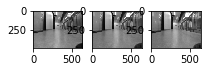

In [10]:
if __name__ == "__main__":
    stack_size = 1
    dataset = ControlsDataset(stack_size, classes = classes)
    dataset.convertTOClass()
    dataloader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 0)
    print(dataset.data_frame["Angle"].unique())
    print(len(dataset.data_frame["Angle"].unique()))
    print(dataset.data_frame.head(10))
    """
    for i_batch, sampled_batch in enumerate(dataloader):
        #print(sampled_batch['control'][0])
        print(sampled_batch["control"])
        print("-------------------------")
    """
    
    img_stack = dataset[0]['image']
    f, ax = plt.subplots(stack_size, 3, figsize=(3*stack_size,25))
    ax = ax.reshape((stack_size,3))
    for k in range(3*stack_size):
        i,j = k//3, k % 3
        ax[i,j].imshow(img_stack[k],cmap='gray')
    